# Two photon monolayer

- Ideas concerning the scan of a mono-layer made of FIB molecules and interrogated through 2p laser absorption 

In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from IPython.display import Image
from IPython.display import Math
from IPython.display import Latex

In [39]:
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Fri Apr 26 10:23:01 2019


In [40]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tables            as tb
import random
import glob
import warnings
sns.set()

In [41]:
from  invisible_cities.core.system_of_units import *

In [42]:
from sabat.sbt_types import FoV, CircularFoV, Monolayer
from sabat.sbt_types import Laser, PulsedLaser, GLaser, GaussianBeam
from sabat.sbt_types import Molecule
from sabat.sbt_types import Molecule2P
from sabat.sbt_types import DyeSample
from sabat.sbt_types import Microscope
from sabat.sbt_types import CCD
from sabat.sbt_types import PhotonsPerSample

In [43]:
from sabat.sbt_core import  power_density
from sabat.sbt_core import  photon_density
from sabat.sbt_core import  fluorescence_per_molecule
from sabat.sbt_core import  duration_of_fluorescence
from sabat.sbt_core import  diffraction_limit
from sabat.sbt_core import  photoelectrons_per_pixel
from sabat.sbt_core import  fluorescence_2p
from sabat.sbt_core import  absorbed_photons_per_fluorophore_per_pulse_2p
from sabat.sbt_core import  fluorescence_2p
from sabat.sbt_core import  photon_per_sample
from sabat.sbt_core import  signal

In [44]:
from sabat.sbt_types import  photon, molecule, GM, us, ucm2, ucm3, gp 

In [45]:
from sabat.FIB import  FIB

# Relevant papers

https://www.osapublishing.org/DirectPDFAccess/6D7E7982-90AC-2FC4-1BC45ECB85CF58B0_33721/josab-13-3-481.pdf?da=1&id=33721&seq=0&mobile=no

http://www.aomf.ca/pdfs/Denk1990.pdf

See also:

http://micro.magnet.fsu.edu/primer/techniques/fluorescence/multiphoton/multiphotonintro.html

http://xrm.phys.northwestern.edu/research/pdf_papers/chapters/wilson_sheppard_chaps1-5.pdf

https://www.photonics.ethz.ch/fileadmin/user_upload/Courses/NanoOptics/

https://www.newport.com/n/gaussian-beam-optics

## Author

- J.J. Gomez-Cadenas [NEXT](https://next.ific.uv.es/next/) 

#### Contact


- [Email](mailto:jjgomezcadenas@dipc.org)




## The FIB molecule

<img align="center" src="img/FIB252.png" width="600" height="600"></img>

- 8+2+6 Crown     : C826, developed by F. Cossio group. 
- Excitation light: 250 nm results in maximum separation between chelated and unchelated molecules


In [46]:
fib = FIB()

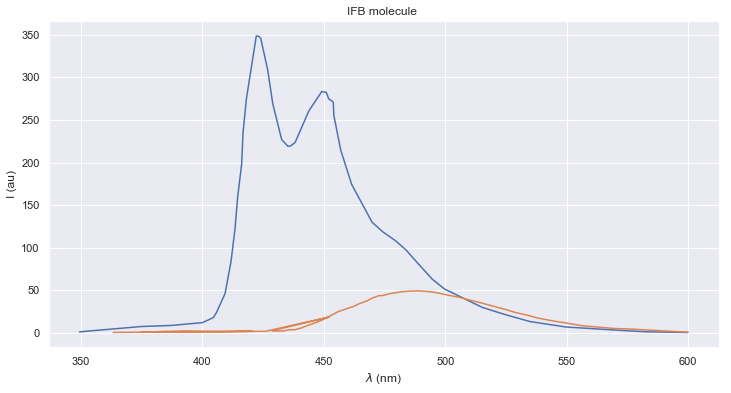

In [47]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)
plt.plot(fib.fibc.L, fib.fibc.I)
plt.plot(fib.fibu.L, fib.fibu.I)
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel("I (au)")
plt.title ("IFB molecule ")
plt.grid(True)

In [48]:
import warnings
from scipy.integrate import quad
SNR = []
EFF = []
lmin = 400
lmax = 500
L   = np.linspace(lmin,lmax)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ict = quad(fib.fibc_spectrum, 350, 550)
    for l in L:
        ic = quad(fib.fibc_spectrum, 400, l)
        iu = quad(fib.fibu_spectrum, 400, l)
        if iu[0] > 0:
            SNR.append(ic[0]/iu[0])
        else:
            SNR.append(0)
        EFF.append(ic[0]/ict[0])

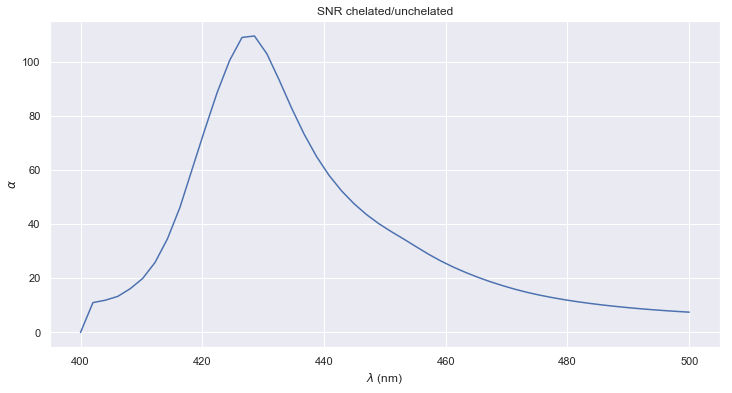

In [49]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)
plt.plot(L, SNR)
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel(r"$\alpha$")
plt.title ("SNR chelated/unchelated")
plt.grid(True)

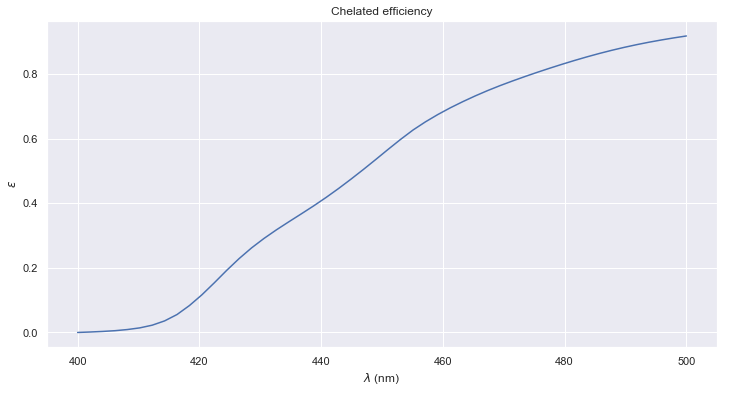

In [50]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)
plt.plot(L, EFF)
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel(r"$\epsilon$")
plt.title ("Chelated efficiency")
plt.grid(True)

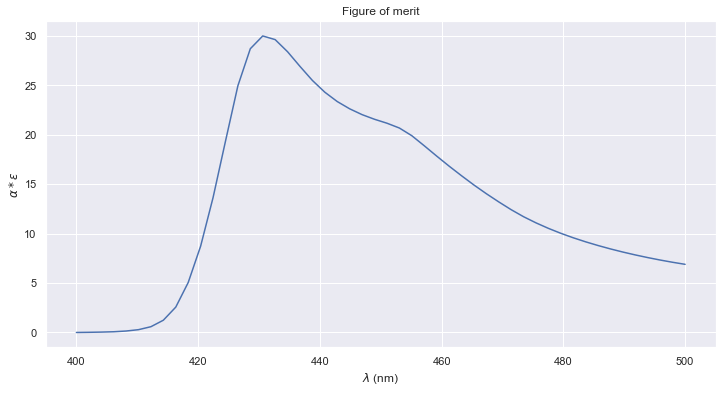

In [51]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)
plt.plot(L, np.array(EFF)*np.array(SNR))
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel(r"$\alpha * \epsilon$")
plt.title ("Figure of merit")
plt.grid(True)

#### Figure of merit maximizes integrating up to 430 nm. This gives $\alpha = 110$ and $\epsilon = 0.3$

## Two Photon Absorption

Two-photon absorption (TPA) is the physical process by which  two photons of identical or different frequencies are absorbed by a molecule. The energy difference between the involved lower and upper states of the molecule equals  the sum of the energies of the two photons absorbed. TPA is a second-order process, typically several orders of magnitude weaker than linear absorption at low light intensities. In TPA the transition rate depends on the square of the light intensity. The non-linear nature of the process can make TPA dominate over linear absorption at high intensities.

Two-photon absorption can lead to two-photon-excited fluorescence (TPEF) where the excited state produced by TPA decays by spontaneous emission to a lower energy state 

<img align="center" src="img/TPEM.png" width="500" height="500"></img>



In two-photon excitation microscopy (TPEM) a pulsed laser beam (often infrared, since many common dyes absorb in the blue) is focused through an objective lens. The  laser pulse width is in the range of 100 femtoseconds and the repetition rate in the range of 100 MHz, allowing the high photon density and flux required for two photons absorption


## Mathematical formulation

Because TPA is a second-order process, the number of photons absorbed per molecule per unit time is proportional to the two-photon absorption cross section $\delta$ and to the square of the incident intensity $I$. In a particular experiment, the total number of photons absorbed per unit time 
$N_{abs}$~ is also a function of dye concentration $C$~ (assumed to be constant in the absence of saturation and photobleaching) and the illuminated sample volume $V$. Thus:

\begin{equation}
N_{abs}(t) = C \delta \int_V I^2({\bf r}, t) dV.
\end{equation}

For the lasers used for TPEM, it is possible to separate the time and space dependent of the excitation intensity, $I({\bf r}, t) = I_0(t) S({\bf r})$. Then:

\begin{equation}
N_{abs}(t) = C \delta I_0^2(t) \int_V S^2({\bf r}) dV.
\end{equation}

Assuming no stimulated emission and self-quenching, the number of fluorescence photons collected per unit time ($F$) is given by:

\begin{equation}
F(t) = \frac{1}{2}\epsilon Q N_{abs}(t).
\end{equation}

Where $\epsilon$~ is the microscope detection efficiency and $Q$~is the quantum efficiency of the dye. The factor 1/2 reflects the fact that two photons are needed for each excitation event.

In practice one measures the time-averaged flux, $<F(t)>$:
\begin{equation}
<F(t)> = \frac{1}{2}\epsilon Q C \delta <I_0^2(t)> \int_V S^2({\bf r}) dV.
\end{equation}

Notice that $<F(t)>$ is proportional to $<I_0^2(t)>$, but the microscope measures a signal proportional to $<I_0(t)>$. Defining:

\begin{equation}
g = \frac{<I_0^2(t)>}{<I_0(t)>^2},
\end{equation}

we can write: 
\begin{equation}
<F(t)> = \frac{1}{2}\epsilon Q C \delta g <I_0^2(t)>^2 \int_V S^2({\bf r}) dV (1).
\label{eq.F}
\end{equation}

### Gaussian laser beam
To compute the integral $\int_V S^2({\bf r})$~it is useful to approximate the laser as a gaussian laser beam, defined as:

\begin{equation}
S({\bf r}) = S(r, z) = \left[ \frac{w_0}{w(z)}\right]^2 e^{\frac{-2 r^2}{w(z)^2}}.
\end{equation}


The parameter $w_0$, usually called the Gaussian beam radius (or beam waist), is the radius at which the intensity has decreased to $1/e^2$~ or 0.135 of its axial, or peak value. At $2 w_0$, or twice the Gaussian radius, the intensity is 0.0003 of its peak value, usually completely negligible.

The evolution with the longitudinal coordinate $z$~of the beam radius is described by the equation:

\begin{equation}
w(z) = w_0 \sqrt{1 + (\frac{z}{z_R})^2}.
\end{equation}

where the Rayleigh radius $z_R$~is defined as:
 \begin{equation}
z_R = \frac{\pi w_0}{\lambda},
\end{equation}

and $\lambda$ is the incident light wavelength. 

If a gaussian beam is focused with a lens of numerical aperture A, the 
$w_0$ is related with the numerical aperture of the lens (in the difraction limist) as:
$$ w_0 = \frac{\lambda}{\pi A}$$

and

$$ z_r =  \frac{\pi w_0^2 }{\lambda} = \frac{\lambda }{\pi A^2}$$

<img align="center" src="img/wz.png" width="500" height="500"></img>


The beam power is obtained integrating the intensity distribution:

\begin{equation}
P = \int_0^\infty I(r, z=0) ~2 \pi r dr =  I_0 \int_0^\infty  2 \pi r e^{-2 r^2/w_0^2} dr (2),
= \frac{1}{2} I_0 \pi w_0^2.
\end{equation}

and thus:

\begin{equation}
I_0 = \frac{2 P}{ \pi w_0^2}.
\label{eq.P}
\end{equation}


The integral of the square of the Gaussian beam to the full volume yields:

\begin{equation}
\int_{V\rightarrow \infty} I^2(r, z) = \int_{-\infty}^\infty dz \int_0^\infty I^2(r, z) ~2 \pi r dr.
\end{equation}

The integral in the radial coordinates is: 

\begin{equation}
\int_0^\infty I^2(r, z) ~2 \pi r dr = \left[ \frac{w_0}{w(z)}\right]^4 \int_0^\infty 2 \pi r e^{-4 r^2/w_0^2} dr
=  \left[ \frac{w_0}{w(z)}\right]^4 \frac{1}{4}  \pi w(z)^2 
= \frac{\pi w_0^4}{4 w(z)^2}
\end{equation}

The integral in the longitudinal coordinate is: 

\begin{equation}
\int_{-\infty}^\infty dz  \frac{\pi w_0^4}{4 w(z)^2} =  
\frac{\pi w_0^4}{4} \int_{-\infty}^\infty \frac{dz}{w(z)^2}  = 
\frac{\pi w_0^4}{4} \int_{-\infty}^\infty \frac{dz}{w_0^2 (1 + (z/z_R)^2)} =
\frac{\pi w_0^2}{4} \pi z_R.
\end{equation}

It follows that for an "infinitely thick sample", we find:

\begin{equation}
\int_{V\rightarrow \infty} I^2(r, z) =\frac{\pi w_0^2}{4} \pi \frac{\pi w_0^2}{\lambda} =
\frac{\pi^3 w_0^4}{4 \lambda} (3)
\label{eq.I}
\end{equation}

Substituting equation (2) and equation  (3) in 
equation (1), we find:

\begin{equation}
<F(t)> = \frac{1}{2}\epsilon Q C \delta g \frac{4 P^2}{\pi^2 w_0^4} \frac{\pi^3 w_0^4}{4 \lambda}
=  \frac{1}{2}\epsilon Q C \delta g  \frac{\pi}{ \lambda} P(t)^2.
\end{equation}

In the calculation above, the refraction index $n$~has been assumed to be 1. Writing it down explicitly we find the expected value of the TPA induced fluorescence under the approximation of a Gaussian laser beam (notice also that the sample is assume to be infinitely thick compared, since we integrate z between $\pm \infty$):

\begin{equation}
<F(t)> = \frac{1}{2}\epsilon Q C \delta g  \frac{n \pi}{ \lambda} P(t)^2 \,\,\,(4).
\label{eq.FF}
\end{equation}

Notice also that, according to equation 4, $F(t)$~does not depend on the beam waist (or equivalently of the numerical aperture). 

### Temporal dependence for a pulse laser

<img align="center" src="img/pulsed_beam.png" width="500" height="500"></img>

The focused intensity obtained from a mode-locked laser is a periodic function of time
defined by the pulse repetition rate (f) and the pulse width (FWHM), $\tau$.  For pulses with a temporal profile one can write:

\begin{equation}
I(t) = I_p \exp{[-4 \log 2 (\frac{t}{\tau})^2]} \,\,\, (5)
\label{eq.GT}
\end{equation}

Because of the periodic nature of the pulse train, one needs to calculate g for only one cycle. 

\begin{equation}
g = \frac{g_p}{f\tau},
\label{eq.gp}
\end{equation}

where:

$$
g_p = \frac{\tau \int_{-1/(2f)}^{1/(2f)} I_0^2(t)}{[\tau \int_{-1/(2f)}^{1/(2f)} I_0(t)]^2} \,\,\, (6)
$$

Substituting (5) into (6), we find: 

\begin{equation}
g_p = \frac{0.75  erf(\frac{2.35}{ 2 f\tau})}{1.134  erf(\frac{1.66}{ 2 f\tau})^2}. 
\end{equation}

Setting $f \tau = 1/2$, we find $g_p = 0.664$.

### TPA fluorescence for a gaussian pulsed beam

Substituting (6) into (4) we find, finally:

\begin{equation}
<F(t)> = \frac{1}{2}\epsilon Q C \delta \frac{g_p}{f \tau}  \frac{n \pi}{ \lambda} P(t)^2. \,\,\, (7)
\end{equation}

Notice that the units are photons per unit time, as expected: 

\begin{equation}
[<F(t)>] = {\rm \frac{molecule}{L^3}\frac{L^4 T}{photon \, molecule}  L^{-1}
\frac{photons^2}{T^2}  =  \frac{photon}{T}}
\end{equation}

## Calculation of yields for Single Photon Absorption (SPA) and Two Photon Absorption (TPA)

#### 1 GM = 1e-50 * cm2*cm2*second / (photon * molecule)

### Molecule
- Assuming until measurement same cross section that for Fluorecein.
- **need to measure the single photon and two photon absorption cross sections for FIB**

In [52]:
fl = Molecule(name = 'FIB', sigma=3E-16 * cm2, Q=0.9)
fl


        Molecule name =FIB; cross section = 3.0e-16 cm2; Q =   0.9
        

In [53]:
fl2 = Molecule2P(name = 'FIB', sigma=3E-16 * cm2, Q=0.9,
                lamda = np.array([500 * nm]), 
                s2    = np.array([10 * GM]))

In [54]:
print(f' Assume TPA cross section for FIB at 500 nm in GM = {fl2.sigma2(500*nm) /GM}')

 Assume TPA cross section for FIB at 500 nm in GM = 10.0


### Laser beam
- The essential parameter in the laser beam is beam repetition, since the power saturates (there are enough photons to guarantee that each fluorophere absorbs two of them). Let's assume a "standard" beam of 100 MHz

In [109]:
lb = PulsedLaser(lamda=500*nm, power=500*mW, f=100*MHZ, tau=100*femtosecond)  
lb


        Pulsed Laser:
        wavelength                =5.0e+02 nm
        photon energy             =2.5e+00 eV
        power                     =5.0e+02 mW
        repetition rate           =1.0e+02 kHz
        pulse width               =1.0e+02 fs
        energy per pulse          =5.0e+04 fJ
        energy per second         =5.0e+02 mJ
        photons per second        =1.3e+18 ph/second
        

### Microscope

In [110]:
mc = Microscope(name='Espinardo', numerical_aperture=0.5, magnification=20, eff_dichroic = 0.85, eff_filter = 0.8 * 0.2) #0.2 for QE of PMT
print(mc)


        name                 = Espinardo
        NA                   =   0.5
        M                    =  20.0
        eff dichroic         =  0.85
        eff filter           =  0.16
        Optical transmission =  0.96
        Filter  transmission =  0.14
        Total transmission   =  0.13
        


In [111]:
gb = GaussianBeam(laser=lb, mc = mc)  
gb


        w0                   =   0.3 micron
        zr                   =   0.6 micron
        DOF                  =   1.3 micron
        

In [112]:
Z = np.linspace(-10 * gb.zr(), 10 * gb.zr())
WZ = [gb.w0wz2(z) for z in Z]

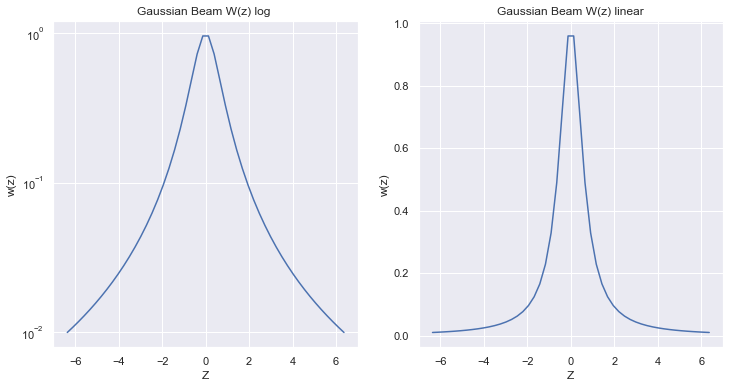

In [113]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
plt.semilogy(Z/micron, WZ)
plt.xlabel("Z")
plt.ylabel("w(z)")
plt.title ("Gaussian Beam W(z) log ")
plt.grid(True)
ax      = fig.add_subplot(1, 2, 2)
plt.plot(Z/micron, WZ)
plt.xlabel("Z")
plt.ylabel("w(z)")
plt.title ("Gaussian Beam W(z) linear")
plt.grid(True)

In [114]:
Z = np.linspace(-5 * gb.zr(), 5 * gb.zr())
WZ = np.array([gb.w(z) for z in Z])
WZm = np.array([-gb.w(z) for z in Z])

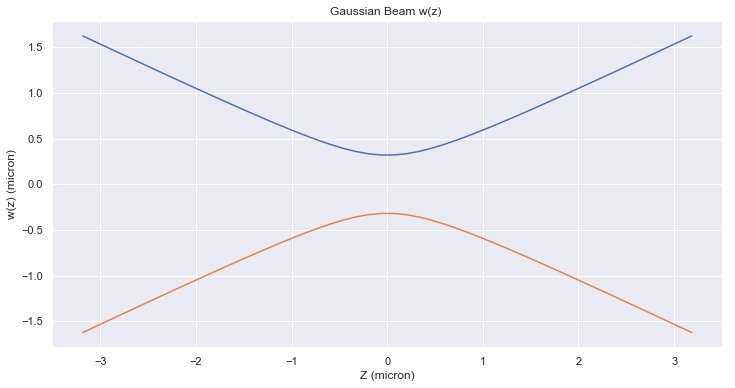

In [115]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 1, 1)

plt.plot(Z/micron, WZ/micron)
plt.plot(Z/micron, WZm/micron)
plt.xlabel("Z (micron)")
plt.ylabel("w(z) (micron)")
plt.title ("Gaussian Beam w(z) ")
plt.grid(True)

### Penetration of gaussian beam**

in R: $2 w_0 = \frac{\lambda}{\pi A}$

in Z : $2  z_R = \frac{2 \lambda}{\pi A^2}$

In [116]:
fov= CircularFoV(d = 2* gb.w0(), z= 2 * gb.zr())
fov


        FOV; d = 6.4e-04 mm; r = 3.2e-04 mm; z = 1.3e-03 mm;
        area = 3.2e-07 mm2 volume = 4.1e-10 mm3
        

### Density of photons in that area

In [117]:
I = photon_density(lb, fov)
print(f'photon density = {I/(us*ucm2):5.1e} photons/(second cm2)')

photon density = 4.0e+26 photons/(second cm2)


In [118]:
print(f'photon density per pulse= {I/lb.tau/(us*ucm2):5.1e} photons/(second cm2)')

photon density per pulse= 4.0e+30 photons/(second cm2)


### Dye 

In [119]:
ds = DyeSample(name='f2p',concentration = 10/6 * nanomole/liter, volume= fov.volume())
ds


        Dye name =f2p;
        concentration = 8.3e-13 mole/l (1.0e+12 molecules/cm3);
        V = 8.1e-13 l,
        nof molecules = 4.1e-01
        

In [100]:
print(f' laser power in photons/second ={lb.n_photons()/us:5.2e}')

 laser power in photons/second =1.26e+18


In [101]:
F = fluorescence_2p(ds, fl2, lb, mc)

In [102]:
print(f' F = {F/us:5.1e} photons/second')

 F = 3.9e+07 photons/second


In [103]:
F2 = F/us
print(f'{F2:5.1e}')

3.9e+07


### According to calculation a large number of fluorescence photons are produced even for small concentrations

## Number of absorbed photons, per fluorophere per pulse

http://www.aomf.ca/pdfs/Denk1990.pdf

- equation 9 (in references)

$$ na = \frac{P^2 Q \sigma_2}{\tau f} (\frac{A^2}{2 \hbar c \lambda})^2$$ (8)

where:
- Q is the quantum efficiency (0.9 for fluorescein)
- $\sigma_2$ is the two photon absorption cross section (in cm$^4$ s)
- A is the numerical aperture
- f is the frequency (e.g, 80 MHZ)
- $\tau$ is the FWHM of the pulse width (e.g, 400 fs)
- P is the laser power
- $\lambda$ is the wavelength of the light

- units are photons/fluorophene


In [104]:
na = absorbed_photons_per_fluorophore_per_pulse_2p(fl2, lb, mc)

In [42]:
print(f' number of absorbed photons per fluorophore per pulse = {na:5.1e}')

 number of absorbed photons per fluorophore per pulse = 2.0e+01


### Thus the laser saturates the molecule in each pulse. The number of emitted photons is simply the number of pulses

In [43]:
n_f = n_pulses_per_second = lb.f/hertz
print(f' number of produced photons per fluorophore per second = {n_pulses_per_second:5.1e}')

 number of produced photons per fluorophore per second = 1.0e+08


In [105]:
N = []
P = np.linspace(50,200,10)
for p in P:
    lb = PulsedLaser(lamda=500*nm, power=p*mW, f=100*MHZ, tau=100*femtosecond)  
    na = absorbed_photons_per_fluorophore_per_pulse_2p(fl2, lb, mc)
    N.append(na)

Text(0, 0.5, '# photons absorbed')

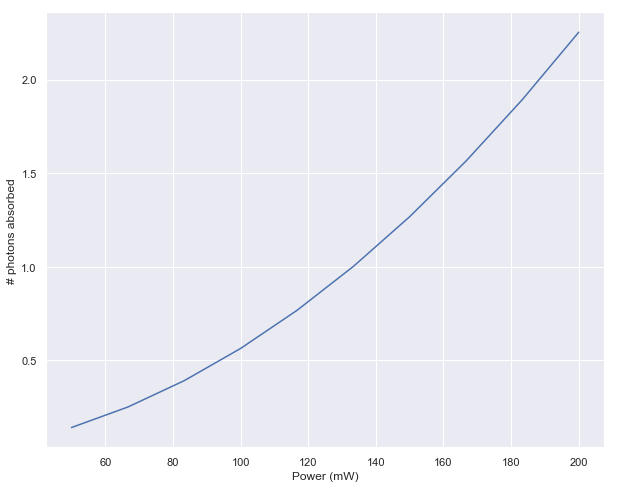

In [107]:
plt.plot(P, N)
plt.xlabel('Power (mW)')
plt.ylabel('# photons absorbed')

# Monolayer

## Signal to noise

- Consider a monolayer spot iluminated by the laser. The spot contains $m$ molecules, of which one molecule is chelated. 
- The number of photons emited by the chelated molecule as a response to the laser pulse will be distributed around $n_p$, where $n_p$ is computed from $n_a$ (equation 8), $n_f = n_a/2)$. Notice that if $n_a$ is larger than 2 (the number of photons that the molecule can absorbe per pulse) then $n_p = 1$. 
- The fluorescence emitted in a given time interval by the chelated molecules will be $n_f$. In a second, with a 100 MHz laser and in the absence of photobleaching, $n_f = 10^8$. 
- The remaining molecules ($m -1 \sim m$, since $m$ is large) will emit (per molecule, in average) $n_f/\alpha$, where $\alpha$ is the ratio of fluorescence between chelated and unchelated molecules (e.g, $\alpha  \sim 100$ for FIB). The total fluorescence emitted by the background molecules will therefore be distributed around $n_b = \frac{n_f \,m}{\alpha}$.
- The signal to noise ration (SNR) is simply:

$$SNR = \frac{n_f}{\sqrt{n_b}} = \frac{n_f}{\sqrt{\frac{n_f \, m}{\alpha}}} = \sqrt{\frac{n_f\, \alpha}{m}} $$

In terms of the number of detected photons we need to multiply by the detection efficiency $\epsilon$. 

$$SNR =  \sqrt{\epsilon \frac{n_f\, \alpha}{m}} $$

In [108]:
print(f' number of absorbed photons per fluorophore per pulse = {na:5.1e}')

 number of absorbed photons per fluorophore per pulse = 2.3e+00


#### This is exactly what is needed to saturate the fluorophore.

In [30]:
power_to_saturate_fluorescence = (2/na) *lb.power
print(f'power_to_saturate_fluorescence={power_to_saturate_fluorescence/mW:5.1e} mW')

power_to_saturate_fluorescence=5.9e+01 mW


### The number of photons per fluorophere per second should then simply be equal to the number of pulses, sice we saturate

In [31]:
n_f = n_pulses_per_second = lb.f/hertz
print(f' number of produced photons per fluorophore per second = {n_pulses_per_second:5.1e}')

 number of produced photons per fluorophore per second = 1.0e+08


## We can read the PMT at vr MHz

In [32]:
def readout_frq(vr : float = 100 * MHZ)->float:
    return 1./(vr/hertz)

In [33]:
readout_frq(vr  = 1 * hertz)

1.0

#### alpha is the molecule signal to ratio

In [34]:
alpha = 100 

In [36]:
nps = photon_per_sample(n_f, readout_frq(1 * hertz), alpha, mc)
nps


        ns_ph = 1.0e+08 ; ns_det = 1.3e+07 ; nb_ph= 1.0e+06 ; nb_det = 1.3e+05
        

### Assuming detection efficiency = 1

In [38]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_ph, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 1.0e+08
        n_b               = 1.0e+06
        alpha (snr c/u)   = 1.0e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 1.0e+12
        snr               = 1.0e+02
        

### Taking into account the detection efficiency

In [39]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 1.3e+07
        n_b               = 1.3e+05
        alpha (snr c/u)   = 1.0e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 1.3e+11
        snr               = 3.6e+01
        

### Statistical test

run 1000 experiments in 25.546162843704224 seconds


(array([  2.,   5.,  47., 130., 252., 298., 183.,  67.,  15.,   1.]),
 array([11555976.55586243, 11811814.79977875, 12067653.04369507,
        12323491.28761139, 12579329.53152771, 12835167.77544403,
        13091006.01936035, 13346844.26327667, 13602682.50719299,
        13858520.75110931, 14114358.99502563]),
 <a list of 10 Patch objects>)

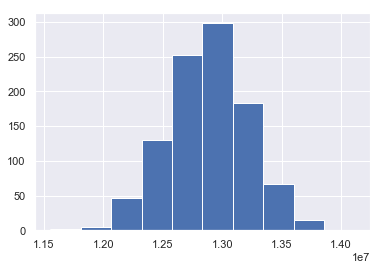

In [40]:
n  = int(1e+3)
t0 = time.time()
N = [ml.nsignal() for i in range(n)]
t1 = time.time()
print(f'run {n} experiments in {t1-t0} seconds')
plt.hist(N, bins=10)

In [41]:
np.average(N) / np.std(N)

38.080677590803944

In [42]:
n  = int(1e+3)
t0 = time.time()
N  = signal(ml, n_exp = n)
t1 = time.time()
print(f'run {n} experiments in {t1-t0} seconds')

run 1000 experiments in 25.00779700279236 seconds


(array([  5.,  19.,  46., 129., 241., 245., 185.,  96.,  30.,   4.]),
 array([0.90209252, 0.9207116 , 0.93933067, 0.95794975, 0.97656882,
        0.9951879 , 1.01380698, 1.03242605, 1.05104513, 1.0696642 ,
        1.08828328]),
 <a list of 10 Patch objects>)

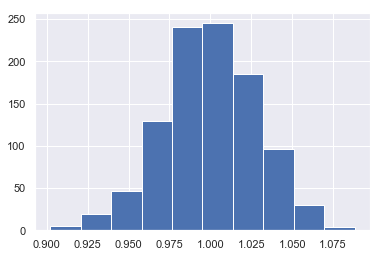

In [43]:
plt.hist(N, bins=10)

In [44]:
np.average(N) / np.std(N)

34.8021511643825

### In 100 ms

In [45]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det/10, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 1.3e+06
        n_b               = 1.3e+04
        alpha (snr c/u)   = 1.0e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 1.3e+10
        snr               = 1.1e+01
        

### In 10 ms

In [46]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det/100, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 1.3e+05
        n_b               = 1.3e+03
        alpha (snr c/u)   = 1.0e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 1.3e+09
        snr               = 3.6e+00
        

#### Thus one could get to 10 ms steps with a 100 MHz beam and in the absence of photobleaching. Ways to improve:
- Use a GHz laser (feasible).
- Use plasmonic amplification. 

#### Photobleaching
- Photobleaching (PB) will burn the molecule if it emits more than a given number of photons. 
- It appears that with 10^5 photons is possible to identify the molecule. Thus if PB is below that range, we are OK. 
- Notice that all molecules emit, so if PB occurs at low values of light emmission the scan would burn the target.
- PB for fluorescein occurs at 360,000 photons in deoxygenated environment.
- The FIB molecule will work in dry medium, with very small amounts of oxygen. The feasibility of the experiment depends of a PB level being sufficiently low, but that appears reasonable given the PB level of Fluorescein. 
- Alternatively plasmonic amplification could amplify the signal and avoid reaching PB criticality.

## Scanning time

- In a monolayer molecules will be packed at 1 nm separation. The ML itself will be 1 nm thick.
- Assume that the beam will illuminate a region of 1 mu2. 
- Then, if the mirror speed can be tuned to 1 khz, one could cover 1E+3 points per second. 
- Assuming that 1 ms exposure is enough, one can use an array of beams to cover the transverse coordinate.
- Using 20 beams, one needs 50 seconds to cover the 1 mm2 sample, which appears reasonable!
- If each point takes longer (e.g, above, 10 ms), one could still be OK (500 s scan is less than 10 minutes). 

# What about Single Photon Absorption (SPA)?

- One needs a fs  pulsed laser, rather than a CW laser. Otherwise the excess power (even more at 250 nm) will destroy the molecule. 
- No such lasers available for excitation in the UV (e.g, 250 nm)
- Not obvious how to focus SPA (can't use TIRF in dry medium).
- TPA seems preferred!

### Calculation with FIB

In [47]:
readout_f =0.3
alpha = 110
n_f = 1e+8

In [48]:
nps = photon_per_sample(n_f, readout_f, alpha, mc)
nps


        ns_ph = 3.0e+07 ; ns_det = 3.9e+06 ; nb_ph= 2.7e+05 ; nb_det = 3.5e+04
        

In [49]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 3.9e+06
        n_b               = 3.5e+04
        alpha (snr c/u)   = 1.1e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 3.5e+10
        snr               = 2.1e+01
        

In [50]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det/10, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 3.9e+05
        n_b               = 3.5e+03
        alpha (snr c/u)   = 1.1e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 3.5e+09
        snr               = 6.6e+00
        

In [51]:
ml = Monolayer(x= 1 * mum, y = 1 * mum, z = 1 * nm, nf = nps.ns_det/100, alpha=alpha)
ml



        x = 1.0e+00 mum; y = 1.0e+00 mum; z = 1.0e+00 nm; area = 1.0e+00 mum2 volume = 1.0e-03 mum3
        n_f               = 3.9e+04
        n_b               = 3.5e+02
        alpha (snr c/u)   = 1.1e+02
        m (nof molecules) = 1.0e+06
        n_f * m / alpha   = 3.5e+08
        snr               = 2.1e+00
        

### With FIB we need 100 ms to achieve S/N = 6.6. 

### Summary
- The molecule emits 1E+7 photons, but we can only use 30 % (to separate chelated and unchelated molecules) x 10 % (detection efficiency).
- If photobleaching occurs at a lower level than 1e+7,the technique will not work.
- Thus the challeges are: increase detection efficiency, increase molecular separation and design a molecule that doest no photobleach in dry atmosphere. 
- Alternatively we need to amplify the signal by plasmonic anthena, so that we reduce the amount of light that is absorbed by the molecule. 